## **Movie Recommendation Engine**
We will be building our own movie recommendation system using Tensorflow. This means that the model will be trained on the interactions of many users to make recommendations for a single user.

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
import zipfile
import collections
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

### Step 1: Preparing the Data

First we must download the data we want to use. We will be using a MovieLens dataset, which is a dataset containing user rating data for movies collected from 1900s to 2000s. It contains data about movie ratings, movie meta data (such as genres and year), and user data (such as age, gender, etc.)
In our system, we will only use the bare minimim of user_id, movie_id, and user_rating because only having this data is a more realistic example. It is very rare in the real world to be able to have more features about users and movies, so we will be approaching this problem in a broadly applicable case.

In [32]:
# Download MovieLens data.
print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


Next, we will insert the data into variables.

In [33]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

We must also get through some more pre-processing steps to set up our dataframes.

In [34]:
# The movies file contains a binary feature for each genre.
genre_cols = ["genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
print(movies['release_date'])
# Since the release_data info is in 01-Jan-1995 format, we will split the eyar string into 3 components and choose just the last one, giving us only the year.
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
print(movies["year"])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

0       01-Jan-1995
1       01-Jan-1995
2       01-Jan-1995
3       01-Jan-1995
4       01-Jan-1995
           ...     
1677    06-Feb-1998
1678    06-Feb-1998
1679    01-Jan-1998
1680    01-Jan-1994
1681    08-Mar-1996
Name: release_date, Length: 1682, dtype: object
0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
1677    1998
1678    1998
1679    1998
1680    1994
1681    1996
Name: year, Length: 1682, dtype: object


In [35]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

print(movielens.head())
print(movielens.columns)

   user_id  movie_id  rating  unix_timestamp  \
0      195       241     3.0       881250949   
1      195       256     2.0       881251577   
2      195       110     4.0       881251793   
3      195        24     4.0       881251955   
4      195       381     4.0       881251843   

                                               title release_date  \
0                                       Kolya (1996)  24-Jan-1997   
1                                Men in Black (1997)  04-Jul-1997   
2                Truth About Cats & Dogs, The (1996)  26-Apr-1996   
3                               Birdcage, The (1996)  08-Mar-1996   
4  Adventures of Priscilla, Queen of the Desert, ...  01-Jan-1994   

   video_release_date                                           imdb_url  \
0                 NaN    http://us.imdb.com/M/title-exact?Kolya%20(1996)   
1                 NaN  http://us.imdb.com/M/title-exact?Men+in+Black+...   
2                 NaN  http://us.imdb.com/M/title-exact?Truth%20Abou

Lastly, split the dataframe into training and testing. We will also be saving the number of rows, unique users, unique movies, and unique movie IDs for the future.

In [36]:
train, test = train_test_split(movielens, test_size=0.1)
train.head()

ROW_COUNT = train.shape[0]
EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

Side Note: **Cold Start Problems**\
A big thing to think about here is how we create our test/training split. Looking at the dataframe, we see that our data has a timestamp. That means if depending on when the user interacted, we could end up with users being only in the training or only in the testing if we decide to sort by timestamp and then split the data according to some ratio. This is an example of what is called a <ins>cold-start problem<ins>. \

Cold start is a potential problem in recommender systems where the system cannot draw any inferences for users due to a lack of information. Here are 3 well-established cases:\
- New Community: No users are present and therefore no interactions have been observed
- New item: New item with no interactions
- New user: New user with no interactions --> don't know preferences

The impact of cold start problems are usually mitigated by things such as user profile information, where the system will have at least some basis to go by. In our case, we will be utilizing a **collaborative filter**. This is a method of making automatic predictions about the interests of a user by collecting information from many other users. It assumes that the user or item has some ratings, from which it can then infer the ratings of similar users or items.


### Step 2: Matrix Factorization
Creating Embeddings
1. Specify the embedding dimension (how long the vector should be.)
2. Initialize embeddings (weights)
3. Training to push the embeddings to be more useful.

In our case we will be using the Funcitonal API notation to create embeddings for the user and movies, then merging them together through a dot product.

In [37]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):

    # the input layer are all raw user_IDs --> 1 dimension shape
    # NOTE: we use Functional API notation where we are specifying the layer input explicitly
    user_input = keras.Input(shape=(1,), name='user_id')
    # create an embedding layer with these IDs as imput and with EMBEDDING_SIZE
    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    # adding user bias
    user_bias = layers.Embedding(input_dim=NUM_USERS, output_dim=1, name='user_bias')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)
    user_model = keras.Model(inputs=user_input, outputs=user_vec)

    # do the same thing with the movies
    movie_input = keras.Input(shape=(1,), name='movie_id')
    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    # adding movie bias
    movie_bias = layers.Embedding(input_dim=NUM_MOVIES, output_dim=1, name='movie_bias')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)
    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)

    # take the dot product of the two embeddings to approximate our ranking matrix
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    # add bias terms
    add = layers.Add()([merged, user_bias, movie_bias])
    flatten = layers.Flatten()(add)

    # Apply Activation Function.
    # Note: Since we want our recommendations to be from 0 to 5 rather than 0 to 1, we must apply an activation function to reflect that.
    flatten = 4 * tf.nn.sigmoid(flatten) + 1

    # model input/output definition
    # In the Funcitonal API we bind all layers together in the keras.Model layer by defining the starting point and the last layer.
    model = keras.Model([movie_input, user_input], outputs=flatten)
    # we then compile with the specification of the loss function.
    model.compile(loss= 'mean_absolute_error')
    return model, movie_model, user_model

model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)


### Step 3: Fitting the Model
We must now fit on the training data with the ratings being the target. We will use the test data as our validation data.
We also define a callback statement, which means we are setting up flags to track our model through the training. EarlyStopping monitors if a metric stopped improving (in our case the model loss). The patience parameter is the number of epochs to be waited until termination. ModelCheckpoint saves the model results, with save_best_only controlling whether to restore only model weights from the epochs with the best value of the monitored quanitity.

In [38]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1,
                              callbacks = callbacks)

model.summary()

Epoch 1/50
900/900 [==============================] - 5s 4ms/step - loss: 0.9889 - val_loss: 0.8726
Epoch 2/50
 89/900 [=>............................] - ETA: 1s - loss: 0.8170

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


900/900 [==============================] - 2s 2ms/step - loss: 0.7826 - val_loss: 0.7763
Epoch 3/50
900/900 [==============================] - 2s 2ms/step - loss: 0.7271 - val_loss: 0.7507
Epoch 4/50
900/900 [==============================] - 4s 5ms/step - loss: 0.7023 - val_loss: 0.7413
Epoch 5/50
900/900 [==============================] - 3s 3ms/step - loss: 0.6870 - val_loss: 0.7334
Epoch 6/50
900/900 [==============================] - 3s 3ms/step - loss: 0.6760 - val_loss: 0.7286
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6673 - val_loss: 0.7256
Epoch 8/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6600 - val_loss: 0.7240
Epoch 9/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6539 - val_loss: 0.7225
Epoch 10/50
900/900 [==============================] - 3s 3ms/step - loss: 0.6489 - val_loss: 0.7215
Epoch 11/50
900/900 [==============================] - 3s 3ms/step - loss: 0.6441 - val_loss: 0.7193
Epoch 12/

Now that we have completed the Matrix Factorization, we can visualize what we have produced as well as its loss function.

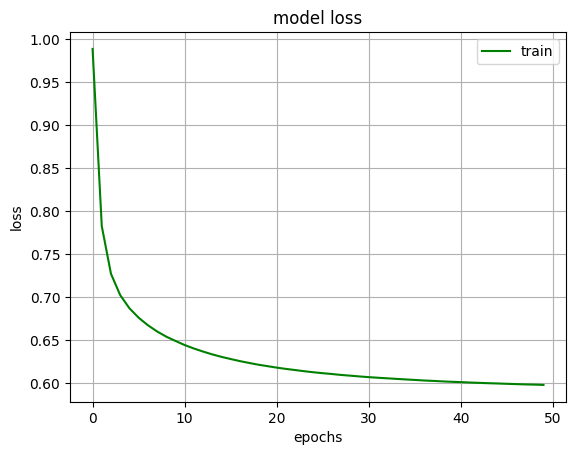

In [39]:
keras.utils.plot_model(model, show_shapes=True)

# Plot the loss curve
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

### Step 4: Analyze the Results
Now we can predict movie ratings for a fixed user as well as likely users for a fixed movie. To do so, we implement a neraest neighbor algorithm. \
The KNN Classifier needs a list as an input, so we first convert the movie embedding into a list. The output of the embedding layer is an ndarray which is a NumPy class for representing multidimensional arrays.

In [40]:
# Nearest Neighbor Recommendation

# Top-K Candidates using K-Nearest Neighbor
# Now that we have the embeddings, we can apply the nearest neighbor algorithm to recommend movies to users.
# We can get user_embedding from the user_id and find out what are the movies that are close to the
# user_embedding in the embedding space. We use K-Nearest Neighbor algorithm for this purpose.

knn_train_label = UNIQUE_MOVIE_IDS
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

print(type(movie_model.predict(np.array([10]))))

for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

1/1 [==============================] - 0s 46ms/step
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 21ms/step


KNeighborsClassifier(n_neighbors=11)

We can now define a funciton to return the recommended movies for a specific user.

In [41]:
def recommend_movies(embedding):
    distances, indices = knn.kneighbors(embedding.reshape(1, -1), n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']

TEST_USER_ID = 200
print(TEST_USER_ID)
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]
print(recommend_movies(user_embedding))

200
1/1 [==============================] - 0s 76ms/step
0         Kull the Conqueror (1997)
1              Marvin's Room (1996)
2                 Rising Sun (1993)
3               Citizen Ruth (1996)
4    Raiders of the Lost Ark (1981)
5               Crimson Tide (1995)
6          Last Man Standing (1996)
7                      Crash (1996)
8                  Pollyanna (1960)
9                      Fargo (1996)
Name: title, dtype: object


### Step 5: Visualizing the Embedding Space
Trying to create a visual representation of the embedding space is very difficult as we must create a 2D projection of it. So, we must use a special package called t-SNE, which stands for t-Distributed Stochastic Neighbor Embedding. This is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. The first step in this process is by constructing a probability distribution over pairs of high-dimensional objects so that similar objects are assigned a higher probability while dissimilar points are give a lower probability. Then, t-SNE defines a similar probability distribution over the points in a low-dimensional map.

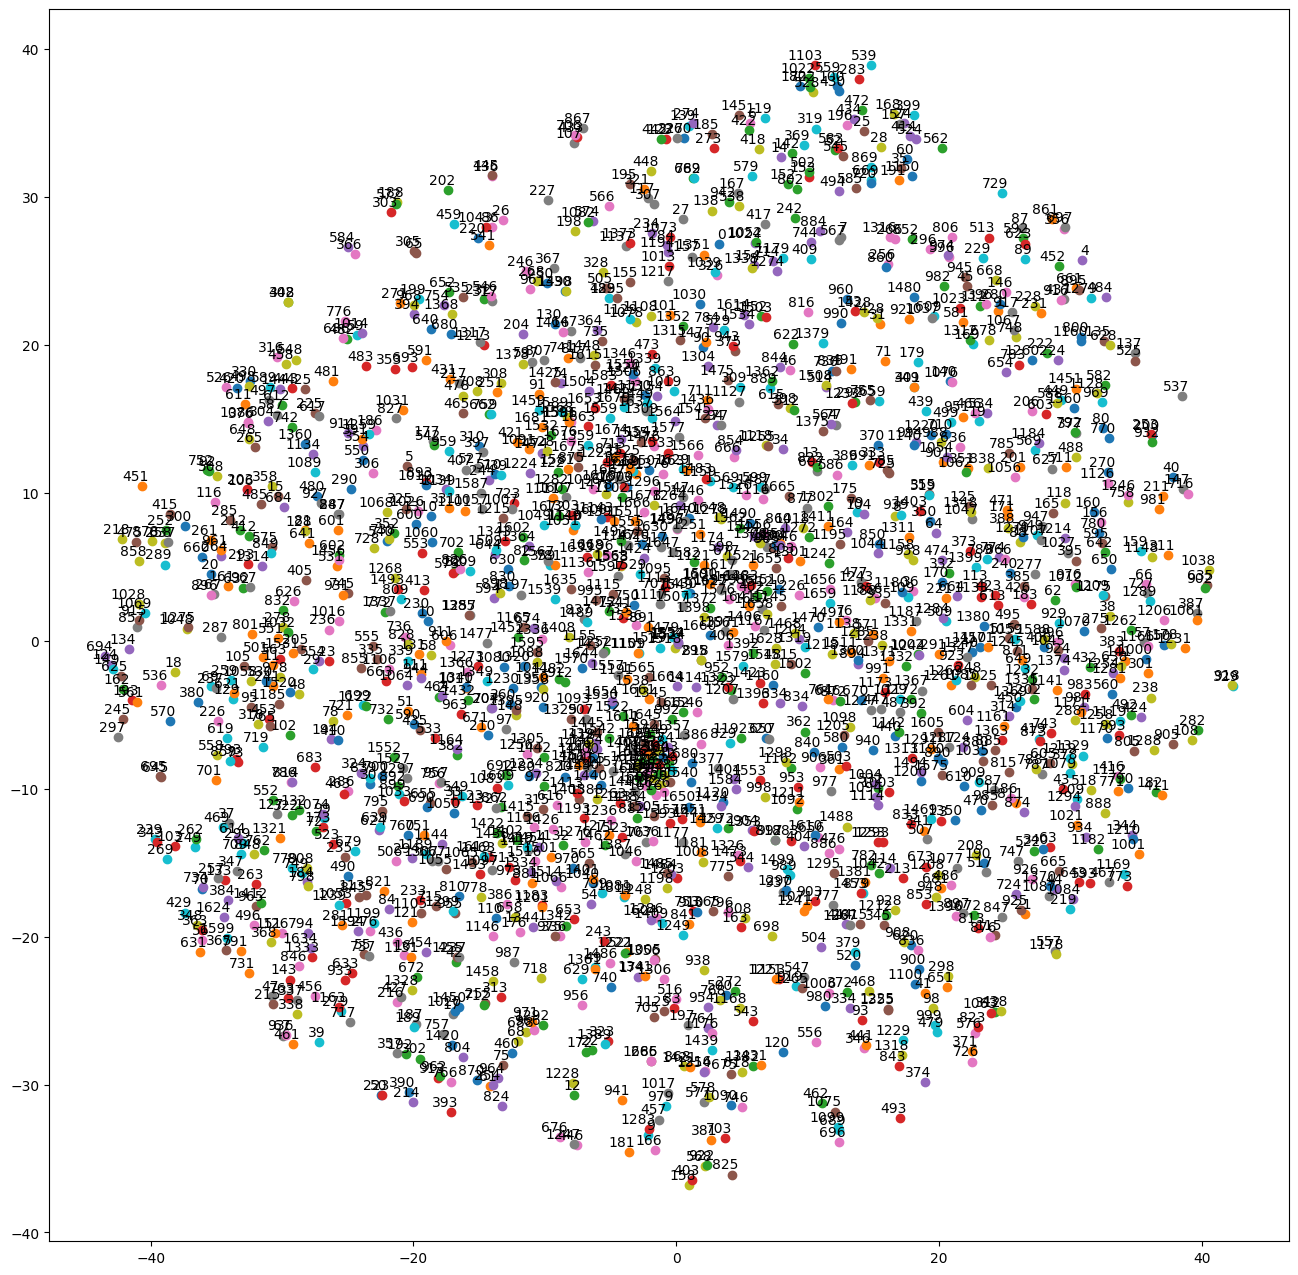

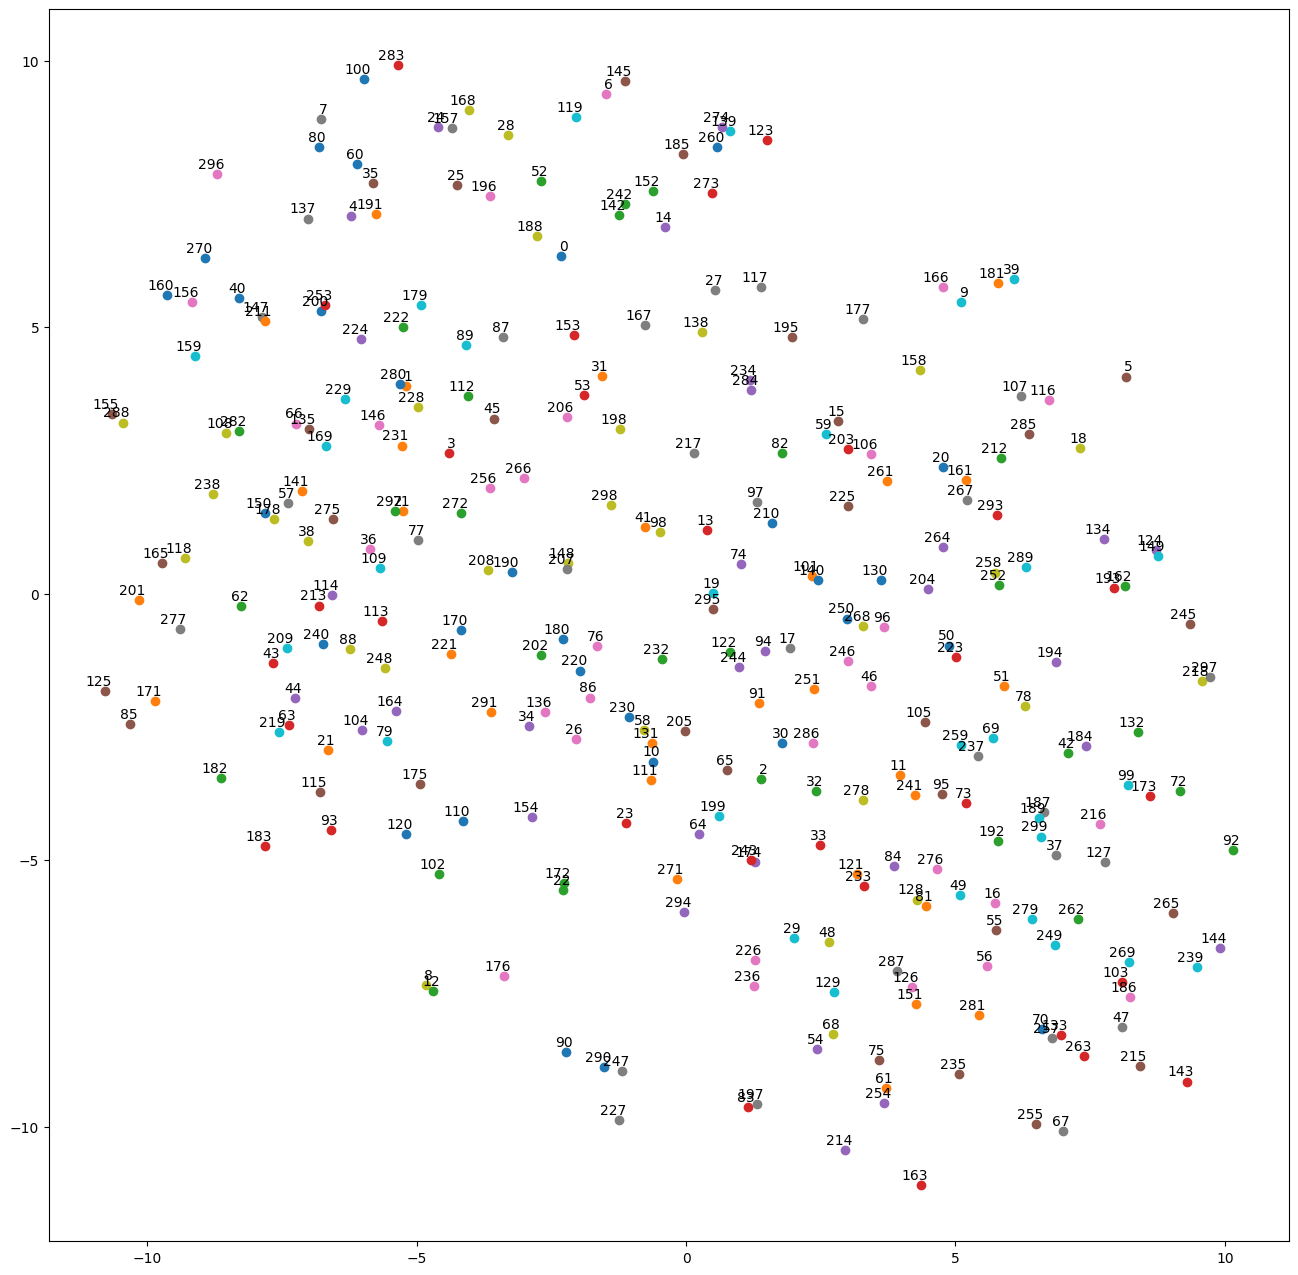

In [42]:
from sklearn.manifold import TSNE

MOVIE_EMBEDDING_LIST = np.array(MOVIE_EMBEDDING_LIST)

def tsne_plot(model, MOVIE_EMBEDDING_LIST, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

tsne_plot(model, MOVIE_EMBEDDING_LIST)

# Plot only first 300 Movies
tsne_plot(model, MOVIE_EMBEDDING_LIST, 300)

Let's see how the average rating for movie id 283, 100 and 11 looks like. From the above figure, movie id 283 and 100 should have similar ratings, but very different from movie id 11.


In [44]:
print(np.average(movielens.loc[movielens['movie_id'] == 283, 'rating'], axis=0))
print(np.average(movielens.loc[movielens['movie_id'] == 100, 'rating'], axis=0))
print(np.average(movielens.loc[movielens['movie_id'] == 11, 'rating'], axis=0))

3.160621761658031
3.26027397260274
4.385767790262173
